<a href="https://colab.research.google.com/github/binrey/stickoff/blob/master/vgg16%2Bimaug.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
import sys
drive.mount('/content/gdrive')
sys.path.insert(0, '/content/gdrive/My Drive/stickoff')
#sys.path.insert(1, '/content/gdrive/My Drive/Colab Notebooks')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
from __future__ import print_function
import numpy as np
import os
import pandas as pd
from matplotlib import pyplot as plt
from PIL import Image
import imgaug as ia
from imgaug import augmenters as iaa

%pylab inline
plt.rcParams['figure.figsize'] = (7.0, 4.0) # set default size of plots
plt.rcParams['image.cmap'] = 'gray'

Populating the interactive namespace from numpy and matplotlib


In [3]:
trg = pd.read_csv(os.path.join(sys.path[0], "trg.csv"))
trg.head()

,N,Xo,Yo,X1,W
0,0,0.506,0.773,0.536,0.030
1,1,0.502,0.790,0.500,0.034
2,2,0.544,0.662,0.590,0.048
3,3,0.494,0.761,0.520,0.060
4,4,0.512,0.896,0.520,0.020


In [0]:
def load_img(img_id, new_size, aug=True):
    img = Image.open(os.path.join(sys.path[0], "crops/", "img_"+str(img_id+1)+".jpg"))
    imw, imh = img.size
    img_arr = np.array(img, dtype=np.float32)/255
    
    X1 = int(trg.iloc[img_id].X1*imw)
    X2 = int(trg.iloc[img_id].Xo*imw)
    Y1 = imh
    Y2 = int(trg.iloc[img_id].Yo*imh)
    W = int(trg.iloc[img_id].W*imw)
    kmax_crop = 0.3
    maxmax_crops = (int(imw*kmax_crop), int(imh*kmax_crop))
    max_crops = (min(max(min(X1, X2)-int(W/2), 0), maxmax_crops[1]), 
                 min(max(imw-max(X1, X2)-int(W/2), 0), maxmax_crops[0]),
                 min(max(imh-Y2, 0), maxmax_crops[0]))
    
    aug_list = []
    if aug:
        aug_list += [iaa.Crop(px=((0, max_crops[2]),
                                  (0, max_crops[1]),
                                  (0, 0),
                                  (0, max_crops[0]))),
                     iaa.Fliplr(p=0.5)]
    aug_list += [iaa.Resize(new_size)]
    
    seq = iaa.Sequential(aug_list)
    seq_det = seq.to_deterministic()
    
    augmented_kp = []
    kp = []
    
    kp.append(ia.Keypoint(x=int(X1-W/2), y=Y1))
    kp.append(ia.Keypoint(x=int(X1+W/2), y=Y1))
    kp.append(ia.Keypoint(x=X2, y=Y2))
    augmented_kp.append(ia.KeypointsOnImage(kp, shape=img_arr.shape))
    
    img_arr = seq_det.augment_image(img_arr)
    augmented_kp = seq_det.augment_keypoints(augmented_kp)[0].keypoints
    return np.clip(img_arr, 0, 1), augmented_kp
  
def show_img(img, p1, p2, p3):
    x1, y1 = p1
    x2, y2 = p2
    x3, y3 = p3
    
    x0 = int(mean([x1, x2]))
    
    plt.plot([x0, x3], [y1, y3], "--", alpha=0.6);
    plt.plot([x1, x3], [y1, y3], c='blue', linewidth=3, alpha=0.6);
    plt.plot([x2, x3], [y2, y3], c='blue', linewidth=3, alpha=0.6);
    plt.imshow(img);

In [0]:
img_size = [224, 224]
imw = img_size[0]
imh = img_size[1]
n = 2
img, kp = load_img(n, img_size, True)

show_img(img, 
         [min(kp[0].x, kp[1].x), kp[0].y],
         [max(kp[0].x, kp[1].x), kp[1].y],
         [kp[2].x, kp[2].y])

In [0]:
batch_size = 3

x_batch = np.zeros((batch_size, imh, imw, 3))
y_batch = np.zeros((batch_size, 4))

for k in range(0, batch_size):
    
    img, kps = load_img(k, img_size)
    y_batch[k] = np.array([min(kps[0].x, kps[1].x)/imw,
                    max(kps[0].x, kps[1].x)/imw,
                    kps[2].x/imw,
                    kps[2].y/imh])
    x_batch[k] = img

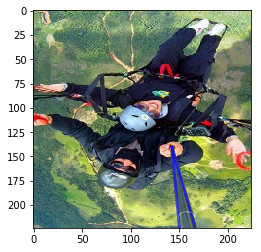

In [75]:
i = 2
show_img(x_batch[i], 
         [y_batch[i, 0]*imw, imh],
         [y_batch[i, 1]*imw, imh],
         [y_batch[i, 2]*imw, y_batch[i, 3]*imh])

In [0]:
y_batch

In [0]:
def getImgData(trgBase, img_type, imgHeight, imgWidth, write_file = False):
# import images into pd-dataframe
    trg = []
    imgList = []

    for i, nImg in enumerate(trgBase.N[:]):
        imgOrigin = importImg(nImg, 500, None, 'crops/')
        print(nImg, end=' ')
        for kHeight, kWidth in [(1, 1)]:#, (1, -0.85), (1, 0.85), (0.85, 1), (0.7, 1)]:
            newHeight = kHeight*imgOrigin.height 
            if kWidth>=0:
                newWidth = [0, kWidth*imgOrigin.width]
                dx = 0
            else:
                newWidth = [(1+kWidth)*imgOrigin.width, imgOrigin.width]  
                dx = 1+kWidth
                
            newXo = (trgBase.Xo.values[i]-dx)/abs(kWidth)
            newX1 = (trgBase.X1.values[i]-dx)/abs(kWidth)
            newYo = trgBase.Yo.values[i]/kHeight+1-1/kHeight
            newW = trgBase.W1.values[i]/abs(kWidth)
            if 0<newXo<1 and 0<newX1<1:
                imgCroped = imgOrigin.crop((newWidth[0], int(imgOrigin.height*(1-kHeight)), newWidth[1], imgOrigin.height))         
                        
                trg.append([newXo, newYo, newX1, newW])
                    
                imgCropedScaled  = imgCroped.resize((imgWidth, imgHeight))
                imgArray = np.power(np.array(imgCropedScaled, dtype=float)/255, 1)
                imgList.append(imgArray.flatten())
    
    trg = pd.DataFrame(data=trg, columns=['Xo', 'Yo', 'X1', 'W'])
    imgData = pd.DataFrame(data=imgList, columns=range(len(imgList[0])))
    if write_file:
        imgData.to_csv('img_data.csv', index=False)
        trg.to_csv('targets_data.csv', index=False)
    print(imgData.shape)
    
    if img_type == 'bw':
        x = imgData.values.reshape(-1, imgHeight,imgWidth, 1)
    else:
        x = imgData.values.reshape(-1, imgHeight,imgWidth, 3)
    
    #for layer in range(1):
    #    xBW = x[:, :,:,layer:layer+1].mean(axis=3)>0.5
    #    x = np.concatenate((x, np.expand_dims(xBW, 3)), axis=3)
    return x, trg

In [0]:
trg = pd.read_csv("targets/coordinates.csv", usecols=["Xo", "X1", "Yo", "W1"])

In [0]:
dir = "crops/"
trg_new = []
img_new = []
mode = 1
for i, row in enumerate(trg.index):
    c = trg.iloc[i]
    img = Image.open(dir+"img_"+str(i+1)+".jpg")
    if img.height>400:
        continue
    if mode==0:
        c_crop = c.copy()
        img_crop = img.crop((0,0,img.height,img.height))
    else:
        c_crop = c.copy()
        
        dx_lim_left = img.width-c_crop.X1-img.height/2
        dx_lim_right = c_crop.X1-img.height/2
        
        dx = 200*(0.5-np.random.random(1)[0])
        dx = -min(dx,dx_lim_right)
        dx = min(dx,dx_lim_left)
        img_crop = img.crop((c_crop.X1-img.height/2+dx,0,c_crop.X1+img.height/2+dx,img.height))
        
        c_crop.Xo += img.height/2-c_crop.X1-dx
        c_crop.X1 = img.height/2-dx
        
        
        
    if c_crop.Xo>img.height or c_crop.X1>img.height or c_crop.Xo<0 or c_crop.X1<0:
        continue
        
    trg_new.append(c_crop)
    img_new.append(img_crop)
    
    print(i, img.size, img_crop.size, c.values, c_crop.values, dx_lim_right, dx_lim_left, dx)    

In [0]:
plt.subplots(figsize=(17,12))
nStart = 60
for nImg in range(nStart, nStart+18):
    plt.subplot(3,6,nImg-nStart+1)
    pylab.imshow(img_new[nImg]);
    X1 = trg_new[nImg].X1
    X2 = trg_new[nImg].Xo
    Y2 = trg_new[nImg].Yo
    W1 = trg_new[nImg].W1
    plt.plot([X1, X2],
                 [img_new[nImg].height, Y2], 
                 c='yellow', 
                 linewidth=3,
                 alpha=0.9);